# Settings

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from sklearn.model_selection import train_test_split

In [5]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [2]:
lst = os.listdir(".\croped_data\images")
lst.sort()

In [4]:
X_train, X_rem= train_test_split(lst, train_size=0.80)

In [6]:
X_valid, X_test = train_test_split(X_rem, test_size=0.4)

In [7]:
print("train :", len(X_train))
print("vaild :", len(X_valid))
print("test :", len(X_test))


train : 124
vaild : 18
test : 13


In [8]:
class_names = ["Tumer", "Invasive Cancer", "else"]

class_values = [[0, 0, 0], [75, 75,75], [255, 255, 255]]

# utils

In [7]:
def concat_mask(image):   
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    # loop over the image, pixel by pixel
    for y in range(0, h):
       for x in range(0, w):
        # threshold the pixel
        channels_xy = image[y,x]
        if all(channels_xy == [29, 29, 29]):
            image[y,x] = [75, 75, 75]
        elif all(channels_xy == [225, 225, 225]):
            image[y, x] = [255, 255, 255]
        elif all(channels_xy == [76, 76, 76]):
            image[y, x] = [75, 75, 75]
        elif all(channels_xy == [204, 204, 204]):
            image[y, x] = [75, 75, 75]
        elif all(channels_xy == [128, 128, 128]):
            image[y, x] = [75, 75, 75]

        # return the thresholded image
    return image

In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [12]:
def get_training_augmentation():
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        #album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        #album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [37]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

# Data Loader

In [10]:
class BuildingsDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join("./croped_data/images", image_id) for image_id in images_dir]
        self.mask_paths = [os.path.join("./croped_data/masks", image_id) for image_id in images_dir]

        self.class_values = class_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = concat_mask(mask)
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

# Train

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    X_train, X_train, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

valid_dataset = BuildingsDataset(
    X_valid, X_valid, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [17]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 60

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./unet_best_model2.pth'):
    model = torch.load('./unet_best_model2.pth', map_location=DEVICE)

In [18]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './unet_best_model2.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 18/18 [00:00<00:00, 27.23it/s, dice_loss - 0.3667, iou_score - 0.5735]
Model saved!

Epoch: 1
valid: 100%|██████████| 18/18 [00:00<00:00, 28.00it/s, dice_loss - 0.3099, iou_score - 0.6148]
Model saved!

Epoch: 2
valid: 100%|██████████| 18/18 [00:00<00:00, 27.29it/s, dice_loss - 0.2608, iou_score - 0.6513]
Model saved!

Epoch: 3
valid: 100%|██████████| 18/18 [00:00<00:00, 28.53it/s, dice_loss - 0.238, iou_score - 0.6728]
Model saved!

Epoch: 4
valid: 100%|██████████| 18/18 [00:00<00:00, 28.42it/s, dice_loss - 0.2383, iou_score - 0.6681]

Epoch: 5
valid: 100%|██████████| 18/18 [00:00<00:00, 27.57it/s, dice_loss - 0.2346, iou_score - 0.6577]

Epoch: 6
valid: 100%|██████████| 18/18 [00:00<00:00, 28.54it/s, dice_loss - 0.2379, iou_score - 0.6578]

Epoch: 7
valid: 100%|██████████| 18/18 [00:00<00:00, 27.50it/s, dice_loss - 0.2326, iou_score - 0.659]

Epoch: 8
valid: 100%|██████████| 18/18 [00:00<00:00, 27.39it/s, dice_loss - 0.2179, iou_score - 0.6748]
Model

# Test

In [35]:
# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./unet_best_model2.pth'):
    best_model = torch.load('./unet_best_model2.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from a previous commit.


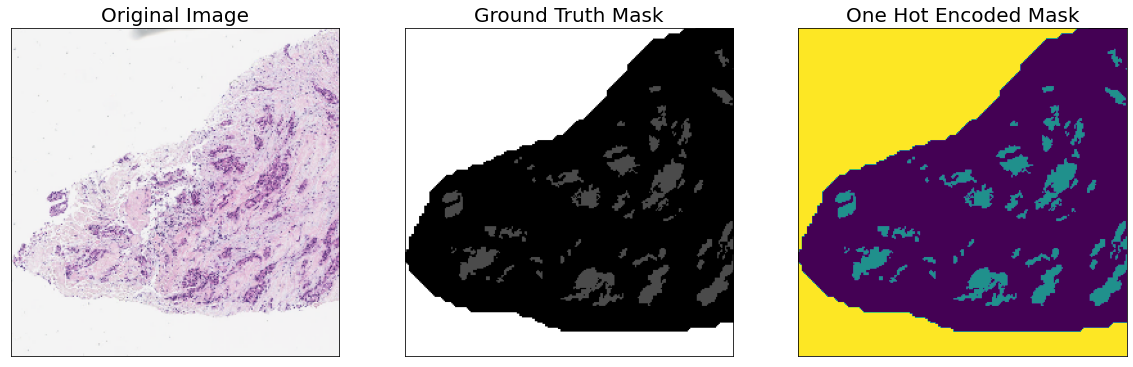

In [36]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    X_test, 
    X_test, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    X_test, X_test, 
    augmentation=get_validation_augmentation(),
    class_values=class_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [38]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 13/13 [00:00<00:00, 32.16it/s, dice_loss - 0.2317, iou_score - 0.6371]
Evaluation on Test Data: 
Mean IoU Score: 0.6371
Mean Dice Loss: 0.2317


# Show results

In [39]:
for idx in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,class_names.index('Tumer')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), class_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), class_values)
   
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

Output hidden; open in https://colab.research.google.com to view.

In [41]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
dice_loss,0.469880,0.359318,0.305830,0.290647,0.264419,0.248649,0.250918,0.234440,0.232608,0.222130,...,0.158833,0.161835,0.162786,0.166994,0.159924,0.156268,0.156086,0.158724,0.157036,0.160453
iou_score,0.440397,0.555727,0.596247,0.598057,0.621989,0.639060,0.628821,0.648478,0.647209,0.658541,...,0.735685,0.730375,0.729076,0.723405,0.734239,0.738966,0.738407,0.735292,0.737851,0.732738


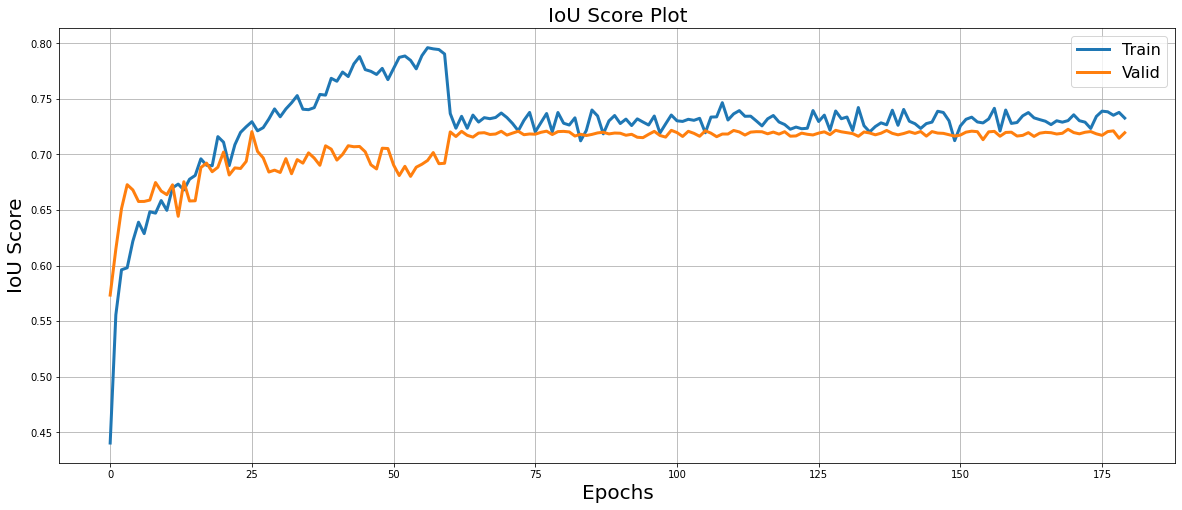

In [42]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

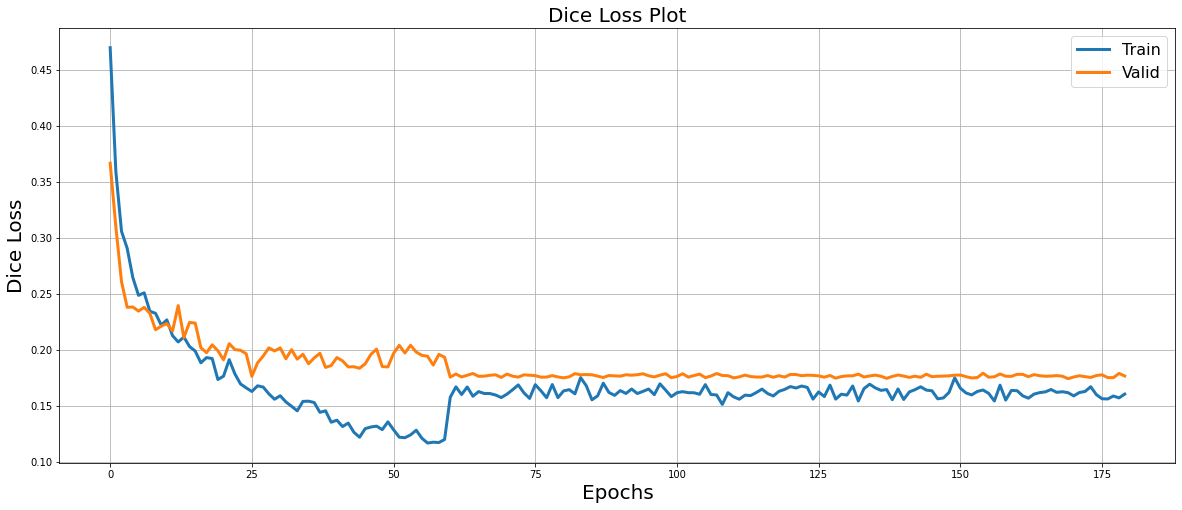

In [43]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()